In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(3145, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3145)              6444105   
Total params: 30,031,817
Trainable params: 29,978,697
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group9_set_224/set_224/train/'
valid_data_dir = '../datasets/group9_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 168612 images belonging to 3145 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 50320 images belonging to 3145 classes.


In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group9_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

3145
{0: '100051', 1: '100167', 2: '100191', 3: '100280', 4: '100338', 5: '100363', 6: '100485', 7: '100490', 8: '100569', 9: '100634', 10: '100682', 11: '100793', 12: '100908', 13: '101166', 14: '101212', 15: '101263', 16: '101460', 17: '101502', 18: '101633', 19: '101660', 20: '101666', 21: '101722', 22: '101728', 23: '10173', 24: '101760', 25: '101834', 26: '101875', 27: '101896', 28: '10196', 29: '101968', 30: '101998', 31: '102008', 32: '102089', 33: '102114', 34: '10221', 35: '102289', 36: '102447', 37: '102534', 38: '102568', 39: '10262', 40: '102643', 41: '102759', 42: '102840', 43: '103034', 44: '103068', 45: '103076', 46: '103099', 47: '103104', 48: '103130', 49: '103198', 50: '103407', 51: '103617', 52: '103692', 53: '103710', 54: '103729', 55: '103752', 56: '103774', 57: '103833', 58: '103847', 59: '103894', 60: '104038', 61: '104039', 62: '104111', 63: '104131', 64: '104141', 65: '104175', 66: '104235', 67: '104322', 68: '104431', 69: '104456', 70: '104503', 71: '104577', 

In [14]:
outputFolder = 'checkpoints_group9'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [15]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [18]:
logs_outputFolder = 'logs_group9'
if not os.path.exists(logs_outputFolder):
    os.makedirs(logs_outputFolder)

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_outputFolder, histogram_freq=1, write_graph=False, write_images=False,
    update_freq='epoch', profile_batch=5, embeddings_freq=1,
    embeddings_metadata=None
)

In [22]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback, tensorboard_callback],
    epochs = 100,
    workers = 8,
    verbose=1
)

Epoch 1/100
2634/2634 [==============================] - ETA: 0s - loss: 6.4782 - acc: 0.0649
Epoch 00001: val_acc improved from -inf to 0.23394, saving model to checkpoints_group9/model-01-0.23.hdf5
2634/2634 [==============================] - 840s 319ms/step - loss: 6.4782 - acc: 0.0649 - val_loss: 4.4421 - val_acc: 0.2339
Epoch 2/100
2634/2634 [==============================] - ETA: 0s - loss: 4.1439 - acc: 0.2632
Epoch 00002: val_acc improved from 0.23394 to 0.37677, saving model to checkpoints_group9/model-02-0.38.hdf5
2634/2634 [==============================] - 843s 320ms/step - loss: 4.1439 - acc: 0.2632 - val_loss: 3.4550 - val_acc: 0.3768
Epoch 3/100
2634/2634 [==============================] - ETA: 0s - loss: 3.3236 - acc: 0.3735
Epoch 00003: val_acc improved from 0.37677 to 0.43768, saving model to checkpoints_group9/model-03-0.44.hdf5
2634/2634 [==============================] - 844s 320ms/step - loss: 3.3236 - acc: 0.3735 - val_loss: 3.0843 - val_acc: 0.4377
Epoch 4/100
2

Epoch 58/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1686 - acc: 0.9507
Epoch 00058: val_acc improved from 0.63871 to 0.64199, saving model to checkpoints_group9/model-58-0.64.hdf5
2634/2634 [==============================] - 836s 317ms/step - loss: 0.1686 - acc: 0.9507 - val_loss: 3.1740 - val_acc: 0.6420
Epoch 59/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1671 - acc: 0.9515
Epoch 00059: val_acc did not improve from 0.64199
2634/2634 [==============================] - 835s 317ms/step - loss: 0.1671 - acc: 0.9515 - val_loss: 3.2564 - val_acc: 0.6156
Epoch 60/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1633 - acc: 0.9525
Epoch 00060: val_acc did not improve from 0.64199
2634/2634 [==============================] - 835s 317ms/step - loss: 0.1633 - acc: 0.9525 - val_loss: 3.3788 - val_acc: 0.6230
Epoch 61/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1619 - acc: 0.9533
Epoch 00061: val_acc did not i

Epoch 88/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1091 - acc: 0.9682
Epoch 00088: val_acc did not improve from 0.65083
2634/2634 [==============================] - 839s 318ms/step - loss: 0.1091 - acc: 0.9682 - val_loss: 3.8640 - val_acc: 0.6104
Epoch 89/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1092 - acc: 0.9684
Epoch 00089: val_acc did not improve from 0.65083
2634/2634 [==============================] - 844s 321ms/step - loss: 0.1092 - acc: 0.9684 - val_loss: 3.5036 - val_acc: 0.6244
Epoch 90/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1053 - acc: 0.9689
Epoch 00090: val_acc did not improve from 0.65083
2634/2634 [==============================] - 845s 321ms/step - loss: 0.1053 - acc: 0.9689 - val_loss: 3.7003 - val_acc: 0.6301
Epoch 91/100
2634/2634 [==============================] - ETA: 0s - loss: 0.1053 - acc: 0.9693
Epoch 00091: val_acc did not improve from 0.65083
2634/2634 [============================

In [ ]:
sfsdfsdsdfs

In [18]:
tf.keras.models.save_model(history.model, 'group11_set224_resnet50_07202020.hdf5', include_optimizer=False)

<Figure size 432x288 with 0 Axes>

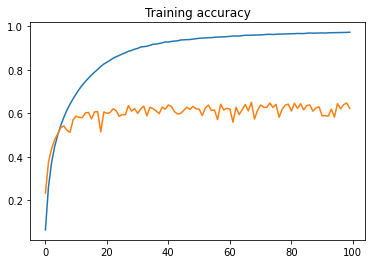

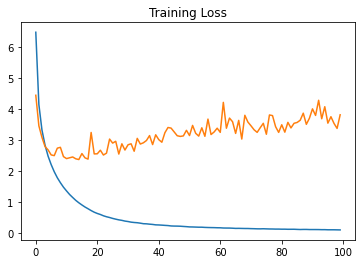

<Figure size 432x288 with 0 Axes>

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg

### Tensorboard

In [24]:
%load_ext tensorboard
import datetime

In [28]:
%tensorboard --logdir logs/train

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 22708.

### Save Labels in  Json file

In [19]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}

In [20]:
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)

1724
{0: '100131', 1: '100474', 2: '10057', 3: '10071', 4: '100719', 5: '100820', 6: '100825', 7: '100847', 8: '100914', 9: '101049', 10: '10116', 11: '101236', 12: '101301', 13: '101462', 14: '101530', 15: '101615', 16: '101664', 17: '101923', 18: '102062', 19: '102241', 20: '102604', 21: '10269', 22: '102703', 23: '102743', 24: '102905', 25: '102959', 26: '102988', 27: '103039', 28: '10308', 29: '103292', 30: '103348', 31: '103365', 32: '103456', 33: '103590', 34: '10367', 35: '103704', 36: '103831', 37: '103923', 38: '104219', 39: '104239', 40: '104457', 41: '104497', 42: '104840', 43: '104882', 44: '10492', 45: '10503', 46: '105274', 47: '105479', 48: '1055', 49: '105597', 50: '105604', 51: '105763', 52: '105806', 53: '105878', 54: '105914', 55: '106128', 56: '106252', 57: '106258', 58: '106401', 59: '106438', 60: '106602', 61: '106653', 62: '106795', 63: '106805', 64: '10694', 65: '106950', 66: '106991', 67: '107233', 68: '107349', 69: '107386', 70: '107404', 71: '107545', 72: '10

In [21]:
with open("group9_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)